<a href="https://colab.research.google.com/github/jan-felix/SLOG/blob/master/SLOG202103_No5/Ex_Ante_vs_Ex_Post_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import pandas_datareader as pdr
import os
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime.today()
index = pd.date_range(start, end, freq="D")
os.environ["ALPHAVANTAGE_API_KEY"] = "H6AXUXK0Z2CBTV59" 

In [2]:
GOVT = pdr.av.time_series.AVTimeSeriesReader(symbols = "GOVT",start = start, end = end).read()
IVV = pdr.av.time_series.AVTimeSeriesReader(symbols = "IVV",start = start, end = end).read()

In [3]:
sampling = "W"
hist_year_window = 1
fut_year_window = 1

if sampling == "W":
  hist_window = hist_year_window * 52
  fut_window = fut_year_window * 52
  pa_value = 52
if sampling == "BM":
  hist_window = hist_year_window * 12
  fut_window = fut_year_window * 12
  pa_value = 12

df =pd.merge(GOVT["close"],IVV["close"], left_index =True, right_index = True)
df.index = pd.DatetimeIndex(df.index)
df = df.resample(sampling).last()

df.columns = ["GOVT","IVV"]
df = df*100/df.iloc[0,:]

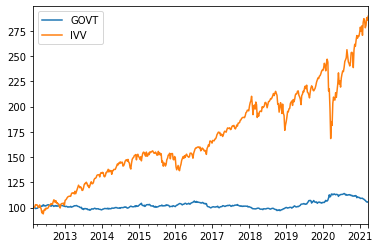

In [4]:
df.plot()

In [5]:
df_ret = df.pct_change().dropna()
cov_govt_ivv = df_ret["IVV"].cov(df_ret["GOVT"])
var_govt = df_ret["GOVT"].var()
var_ivv = df_ret["IVV"].var()
w1 = 0.40
w2 = 1-w1
mark_var = (np.square(w1)*var_govt + np.square(w2)*var_ivv + 2*w1*w2*cov_govt_ivv)*pa_value
mark_std = np.sqrt(mark_var)
mark_std

0.09094714584428301

In [6]:
df_ret.describe()

,GOVT,IVV
count,474.000000,474.000000
mean,0.000134,0.002484
std,0.005571,0.021772
min,-0.021705,-0.148739
25%,-0.002849,-0.007342
50%,0.000394,0.003804
75%,0.003599,0.013735
max,0.027941,0.120874


Idea: 


*   For each week calculate historic 52 week covariances and iterate over 1000 portfolios to find portfolio that is approximately at risk target, with ex ante standard deviation defined by markowitz 2 asset portfolio risk formula (5.6% because for lower, higher risk portfolios there are not always solutions)
*   Take future 52 week covariances and compute the portfolio volatility the target risk portfolio will have over the future 52 weeks
*   Compute 52 weeks realized volatility of a portfolio that rebalances to risk target on a weekly basis. Shift this so that this rebalanced portfolio volatility is in the same period is the other two (for comparison)  



In [7]:
risk_target = 0.056
#For each period (week, month) calculate the historic (co-)variances and iterate over 100 000 portfolios to find portfolio that is at 7.5% risk.
#Make DF with bond weight, portfolio standard deviation and (co-)variances 
lol = list()
for n in range(hist_window, len(df_ret.index)):
  df_a = df_ret.iloc[:n,].tail(hist_window)
  cov_govt_ivv_a = df_a["IVV"].cov(df_a["GOVT"])
  var_govt_a = df_a["GOVT"].var()
  var_ivv_a = df_a["IVV"].var()
  for i in range(0,1001):
    w1 = i/1000
    w2 = 1-w1
    mark_var = (np.square(w1)*var_govt_a + np.square(w2)*var_ivv_a + 2*w1*w2*cov_govt_ivv_a)*pa_value
    mark_std = np.sqrt(mark_var)
    if risk_target == round(mark_std,3):
      lol.append([df_ret.index[n],w1,mark_std,var_govt_a,var_ivv_a,cov_govt_ivv_a])
      break
    if i == 1000: #found no solution
      if mark_std>risk_target: #risk target is being overshot
        w1=1 #only govies
        mark_std = np.sqrt((var_govt_a*pa_value))
      else: #risk target is being undershot
        w1 = 0 #only equities
        mark_std = np.sqrt((var_ivv_a*pa_value))
      lol.append([df_ret.index[n],w1,mark_std,var_govt_a,var_ivv_a,cov_govt_ivv_a])

#Construct dataframe
ex_a_df = pd.DataFrame(lol, columns = ["Date","GOVT_W","ex_a_std","real_VarGOVT","real_VarIVV","real_COV"])
ex_a_df.index = pd.DatetimeIndex(ex_a_df["Date"])
ex_a_df = ex_a_df[["GOVT_W","ex_a_std","real_VarGOVT","real_VarIVV","real_COV"]]

#construct new dataframe 
#1 compute the standard deviation that a portfolio would have had in the next (e.g.) 12 months, that would have achieved the risk target in the previous (e.g) 12 months
#2 compute the (co-)variances that actually happened in the next (e.g.) 12 months (forw_) in the same row as the (co-)variances that happened in the previous time periods (e.g. 12 months)
#3 compute the returns of a portfolio that rebalances in each period based on the weights of the target volatility portfolio
#1 and 3 are different because in 1 we assume weights to be constant for the next 12 months, whereas in 3 we rebalance in each period
#shift 3 back so that it is aligned with 1
df_risk = ex_a_df.copy(deep=True)
for month in ex_a_df.index[:(len(ex_a_df.index)-fut_window)]:
  df_period = df_ret[month:].head(fut_window)
  period_port_ret = (ex_a_df["GOVT_W"][month]*df_period["GOVT"]+(1-ex_a_df["GOVT_W"][month])*df_period["IVV"]) #actual future portfolio returns
  df_risk.loc[month,"ex_p_std"] = period_port_ret.std()*np.sqrt(pa_value) #standard deviation of actual future portfolio returns
  df_risk.loc[month,"forw_COV"] = df_period["IVV"].cov(df_period["GOVT"]) #forward covariance
  df_risk.loc[month,"forw_VarGOVT"] = df_period["GOVT"].var()#forward var
  df_risk.loc[month,"forw_VarIVV"] = df_period["IVV"].var()#forward var

#3
df_risk["IVV_W"] = 1-ex_a_df["GOVT_W"]
df_risk["target_risk_real_ret"] = ex_a_df["GOVT_W"]*df_ret["GOVT"]+df_risk["IVV_W"]*df_ret["IVV"]
df_risk["target_risk_realized_std"] = (df_risk["target_risk_real_ret"].rolling(fut_window).std()*np.sqrt(pa_value)).shift(-fut_window)


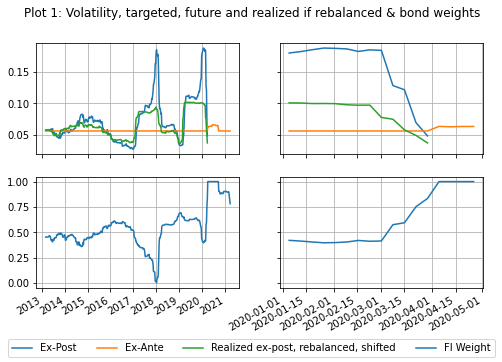

In [8]:
fig, axs = plt.subplots(2,2,figsize =(8,5),sharex="col", sharey="row")
fig.suptitle("Plot 1: Volatility, targeted, future and realized if rebalanced & bond weights")
axs[0,0].plot(df_risk[["ex_p_std","ex_a_std","target_risk_realized_std"]])
axs[0,0].grid()

l1,l2,l3, = axs[0,1].plot(df_risk[["ex_p_std","ex_a_std","target_risk_realized_std"]]["2020-01-01":"2020-05-01"])
axs[0,1].grid()

axs[1,0].plot(df_risk["GOVT_W"])
axs[1,0].grid()

l4, = axs[1,1].plot(df_risk["GOVT_W"]["2020-01-01":"2020-05-01"])
#axs[1,1].legend(labels=["Bond Weights"])
axs[1,1].grid()

fig.legend((l1, l2, l3, l4), ("Ex-Post","Ex-Ante","Realized ex-post, rebalanced, shifted","FI Weight"), 'lower center', ncol = 4)

fig.autofmt_xdate()

From Plot 1 we can see the following: 
*    even the 5.6% risk target cannot always be helt. In 2021 the portfolio derisks 100% and ex-ante risk still increases for us to see it
*    the ex-post volatility that the portfolio weightings of the ex-ante portfolio would have achieved differ very strongly from the risk target -> you canno simply compute a risk targeted portfolio and leave it
*    even the portfolio that rebalances to its risk level on a weekly basis does not manage to keep the risk target. But its doing much better 

Text(0.5, 1.0, 'Variances IVV')

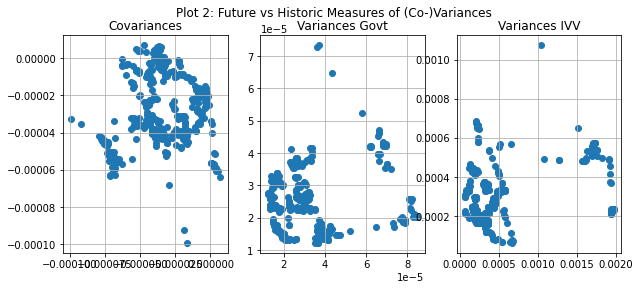

In [9]:
fig, axs = plt.subplots(1,3, figsize=(10,4))
fig.suptitle("Plot 2: Future vs Historic Measures of (Co-)Variances")
axs[0].scatter(x = df_risk["forw_COV"], y = df_risk["real_COV"], marker='o')
axs[0].grid()
axs[0].set_title("Covariances")

axs[1].scatter(x = df_risk["forw_VarGOVT"], y = df_risk["real_VarGOVT"])
axs[1].grid()
axs[1].set_title("Variances Govt")

axs[2].scatter(x = df_risk["forw_VarIVV"], y = df_risk["real_VarIVV"])
axs[2].grid()
axs[2].set_title("Variances IVV")

From Plot 2 we can see that 52 week backward looking and 52 week forward looking variances and covariances simply do not correlate much. This is the reason for the difference in ex ante and ex post volatilities. (Axis can be ignored.)



In [10]:
attribution_df = df_risk[["GOVT_W","IVV_W","ex_a_std","ex_p_std","real_VarGOVT","forw_VarGOVT","real_VarIVV","forw_VarIVV","real_COV","forw_COV"]]
attribution_df["std_dif_ex_p_a"] = df_risk["ex_a_std"]-df_risk["ex_p_std"]
attribution_df["std_w_forw_var"] = np.sqrt((np.square(attribution_df["GOVT_W"])*attribution_df["forw_VarGOVT"]+np.square(attribution_df["IVV_W"])*attribution_df["forw_VarIVV"]+2*attribution_df["real_COV"]*attribution_df["GOVT_W"]*attribution_df["IVV_W"])*pa_value)
attribution_df["std_w_forw_cov"] = np.sqrt((np.square(attribution_df["GOVT_W"])*attribution_df["real_VarGOVT"]+np.square(attribution_df["IVV_W"])*attribution_df["real_VarIVV"]+2*attribution_df["forw_COV"]*attribution_df["GOVT_W"]*attribution_df["IVV_W"])*pa_value)
attribution_df["std_df_due_to_var_surp"] = attribution_df["ex_a_std"] - attribution_df["std_w_forw_cov"]
attribution_df["std_df_due_to_covar_surp"] = attribution_df["ex_a_std"] - attribution_df["std_w_forw_var"]
attribution_results_df = attribution_df[["ex_a_std","std_df_due_to_var_surp","std_df_due_to_covar_surp","std_dif_ex_p_a","ex_p_std"]].dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Ex Post Standard Deviation')

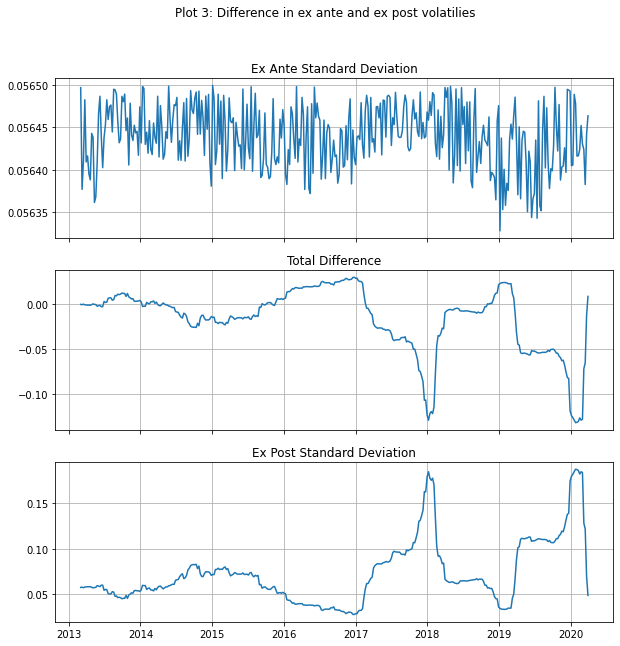

In [11]:
fig, axs = plt.subplots(3,1,sharex=True, figsize=(10,10))
fig.suptitle("Plot 3: Difference in ex ante and ex post volatilies")
axs[0].plot(attribution_results_df["ex_a_std"])
axs[0].grid()
axs[0].set_title("Ex Ante Standard Deviation")
axs[1].plot(attribution_results_df["std_dif_ex_p_a"])
axs[1].grid()
axs[1].set_title("Total Difference")
axs[2].plot(attribution_results_df["ex_p_std"])
axs[2].grid()
axs[2].set_title("Ex Post Standard Deviation")

#attribution_results_df

From Plot 3 we can see: 
*    we only get to 5.6% ex ante vol approximately, but this is due to the fact that we are using only 1000 portfolio combinations and did not solve the optimization equation : /
*    this is marginalized tho by the large difference in ex ante and ex post volatility, which was up to 10 percentage points!

Text(0.5, 1.0, 'Total Difference')

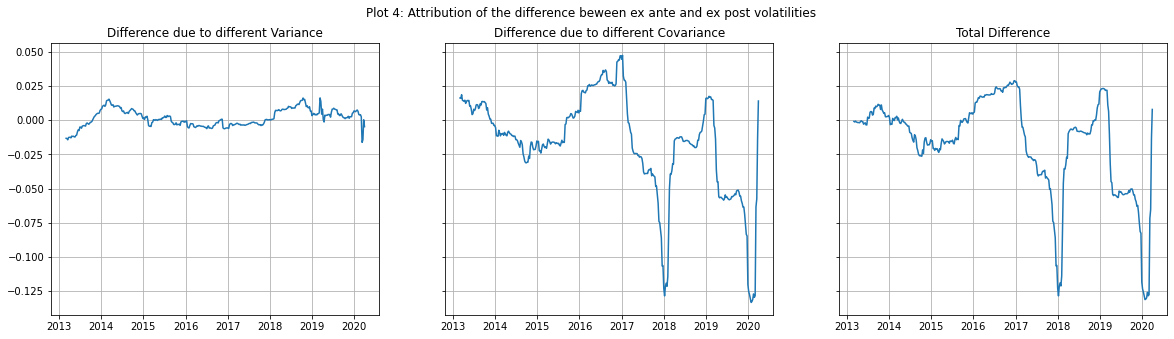

In [12]:
fig, axs = plt.subplots(1,3,sharey=True, figsize=(20,5))
fig.suptitle("Plot 4: Attribution of the difference beween ex ante and ex post volatilities")
axs[0].plot(attribution_results_df["std_df_due_to_var_surp"])
axs[0].grid()
axs[0].set_title("Difference due to different Variance")
axs[1].plot(attribution_results_df["std_df_due_to_covar_surp"])
axs[1].grid()
axs[1].set_title("Difference due to different Covariance")
axs[2].plot(attribution_results_df["std_dif_ex_p_a"])
axs[2].grid()
axs[2].set_title("Total Difference")

For Plot 4: I computed the markowitz equation two more times: 
1.    with the realized covariance (past 52 weeks), but with the volatilties for IVV and GOVT that actually occured (in the next 52 weeks)
2.    with the realized (past 52 weeks) volatilities but with the covariance that actually occured between IVV and GOVT (in the next 52 weeks)

I subtracted the ex ante volatility that only takes past 52 weeks volatility and covariances. By doing this, I can attribute the difference between expected (ex ante) volatility and realized (ex post) volatility to difference in volatilities and differences in correlations. 

Plot 4 shows that the "surprise" in correlations is much more relevant than the "surprise" in volatilties.


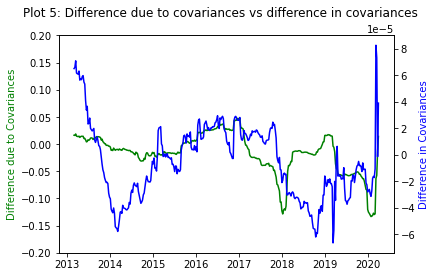

In [13]:
fig, ax1 = plt.subplots()
fig.suptitle("Plot 5: Difference due to covariances vs difference in covariances")
ax2 = ax1.twinx()
ax1.plot(attribution_results_df["std_df_due_to_covar_surp"],'g-')
ax1.set_ylim((-0.2,0.2))
ax2.plot((attribution_df["forw_COV"]-attribution_df["real_COV"]),"b-")

ax1.set_ylabel('Difference due to Covariances', color='g')
ax2.set_ylabel('Difference in Covariances', color='b')

plt.show()

Plot 5 finally *perhaps* shows that, plausibly, the difference in covariances (the covariance surprise) seems to be driving the difference in covariances. It is odd that the two do not align better. Remember the differences are always between 52 weeks past vs 52 weeks future so they should be well aligned...

Inspiration for below analysis: 
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2231195#:~:text=Ex%20post%20volatility%20is%20defined,returns%20over%20the%20measurement%20period.&text=Ex%20ante%20volatility%2C%20on%20the,weights%20and%20asset%20covariance%20estimates.

This does not yet work 100% as expected... obvious reason would be that the annualized squareroots of portfolio variance are not additive in the same way the subcomponents of the variances would be. It is directionally right however (I believe)